**Author:** John Shing Chau Leung

**Description:** A program to use the density data generated from *gaia_cut.ipynb* as input. It compares the Gaia $z$-density data with our prediction generated from our Baryon-DM model and Gaia midplane velocity data (with the help of Poisson-Jeans equation). The output is the log-likelihood exclusion contour for the likelihhod of the Gaia d=tracer density data given our Baryon-DM model.

**date:** 10-10-2018

## library, parameter setting and initalization

integrator.py and analysis.py are custom libraries.

- integrator tasks for solving Poisson-Jeans equation and low level manipulations (e.g. fitting, integration, etc.)

- analysis tasks for mid-level calculation/analysis handling (e.g. statistics and data calculation)

In [29]:
import numpy as np
import scipy.integrate as nint
import scipy.interpolate as interp
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import integrator as intt
import analysis as an

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
plt.style.use("seaborn-bright")
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10
plt.rc('text', usetex=True)

data_folder='/Users/john/Desktop/john_code/DarkDisk/'

raw_gridFile - **output** exclusion grid points before 2D fitting

gridFile - **output** exclusion *rectangular* grid points after 2D fitting

starFile - **input** density profile (format generated by gaia_cut_2.py)

starWFile - **input** mid-plane velocity profile (format generated by gaia_cut_2.py)

From top to bottom:

*delw* : w velocity integration step size

*delz* : z spatial integration step size

*zRangeLarge* : Poisson Jeans solver solution in z-space spanned by $\Phi(z)$

*zRangeMed* : the z-space of interest spanned by the tracer density $\rho(z)$ predicted from $\Phi(z)$. (zRangeMed $\subset$ zRangeLarge) 

*zRangeRed* : z-space of interest for the final likelihood calculation (zRangeRed $\subset$ zRangeMed)

*nBootstrapSample* : number of Bootstrap samples used (not necessary)

*l_range_p/n* : upper/lower range for the likelihood calculation in z-bins

*nStars* : extract the total number of stars in the data file. (to be used with bootstrap statistics)

In [3]:
delw = 0.01
delz = 20.
zRangeLarge = 2600.
zRangeMed = 300.
zRangeRed = 260.
nBootstrapSample = 20
l_range_p = 200.
l_range_n = -200.

zspace = np.linspace(0., zRangeRed, int(zRangeRed/delz))
zspaceMed = np.linspace(0., zRangeMed, int(zRangeMed/delz))
zspaceFull  = np.linspace(-zRangeRed, zRangeRed, 2*int(zRangeRed/delz)-1)
zspaceLarge  = np.linspace(-zRangeLarge, zRangeLarge, 2*int(zRangeLarge/delz)-1)

w_space = np.linspace(0,45,1.5)

/Users/john/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


## Gaia data handling

From the density data file, generate the velocity profile in the Milky Way's midplane.

In [51]:
b_cut_deg = 5.
z_cut_pc = 20.
delw = 2.0
wSun = 7.3

w_Range = 45. # range of w in consideration
delw_fine = 0.001
wNBin = int(w_Range/delw)
uSun = 11.1
vSun = 12.24
vKappa = 4.74047 

zfile_columnl = 1
zfile_columnb = 2
zfile_columnPlx = 3
zfile_columnErrPlx = 4
zfile_columnZ = 5
zfile_columnEVFS = 6
zfile_columnPml = 11
zfile_columnPmb = 12
zfile_columnPmlErr = 13
zfile_columnPmbErr = 14
zfile_columnZErr = 16
zfile_columnVR = 17

single_file = True
star_Cat = 'F'

starFile = ""

if single_file:
   starFile = data_folder+star_Cat+'_stars.txt'
   ldeg, bdeg, plx, z, pml, pmb, evfs_w, zerr, vr = \
      np.loadtxt(starFile, delimiter= ",", skiprows=1, \
          usecols=(zfile_columnl, zfile_columnb, zfile_columnPlx, zfile_columnZ, zfile_columnPml, zfile_columnPmb, zfile_columnEVFS, zfile_columnZErr, zfile_columnVR), unpack=True)
else:
   ldeg = bdeg = plx = z = pml = pmb = evfs_w = zerr = vr = np.array([])
   for i in range(0,10):
      starFile = data_folder+star_Cat+str(i)+'_stars.txt'
      ldeg_d, bdeg_d, plx_d, z_d, pml_d, pmb_d, evfs_w_d, zerr_d, vr_d = \
         np.loadtxt(starFile, delimiter= ",", skiprows=1, \
            usecols=(zfile_columnl, zfile_columnb, zfile_columnPlx, zfile_columnZ, zfile_columnPml, zfile_columnPmb, zfile_columnEVFS, zfile_columnZErr, zfile_columnVR), unpack=True)
      ldeg = np.append(ldeg, ldeg_d); bdeg = np.append(bdeg, bdeg_d); plx = np.append(plx, plx_d)
      z = np.append(z, z_d); pml = np.append(pml, pml_d); pmb = np.append(pmb, pmb_d)
      evfs_w_d = np.append(evfs_w, evfs_w_d); zerr = np.append(zerr, zerr_d); vr = np.append(vr, vr_d)

   
# mid-plane cut and implementation of it on the data   
midplane_cut_indx = (np.abs(bdeg) <= b_cut_deg)
ldeg = ldeg[midplane_cut_indx]
bdeg = bdeg[midplane_cut_indx]
plx = plx[midplane_cut_indx]
pml = pml[midplane_cut_indx]
pmb = pmb[midplane_cut_indx]
evfs_w = evfs_w[midplane_cut_indx]
zerr = zerr[midplane_cut_indx]
vr = vr[midplane_cut_indx]

# convert degrees to radians
lRad = ldeg*np.pi/180.
bRad = bdeg*np.pi/180.

#w-space grid the first one defines the bin edges (for the plt.hist function), the second define the center of bins
w_space_edge = np.linspace(0., w_Range, wNBin+1)
w_space = (w_space_edge + delw/2.)[:-1]
wspace_in = np.linspace(0., w_Range, int(w_Range/delw_fine)+1 )
# calculating VZ = w, use v_r if available, use mean v_r otherwise 
VRMean = -uSun*np.cos(lRad)*np.cos(bRad) - vSun*np.sin(lRad)*np.cos(bRad) - wSun*np.sin(bRad)
   
V_r = np.nan_to_num(vr) + np.isnan(vr)*VRMean
      
VZ =  wSun + vKappa*pmb*np.cos(bRad)/plx + V_r*np.sin(bRad)


fetchWDist_gaia: get the w velocity profile, fit it to a normalized gaussian and bin it according to a wspace (defined in a subroutine in analysis.py). The argument is the file path as a string. Can print fitted parameters as an option (verbose = True).

*fetchZDistHist* : get the z-space tracer star density profile $\rho_{\text{obs}}(z)$ from Gaia data set and bin it according to a user defined z-space bins (zspaceFull). Outputting the binned density profiles in an array. Arguments:

-    starFile - string. Path to the density profile.
-    zspaceFull - np.linspace. Previously defined.
-    use_evfs - whether to use Bovy's evfs (should be stored in starFile). If false, evfs weight = 1.
-    show_plot - plot the density profile.

Mid-plane velocity saved to: grid/star_F_hDD_20_w_data.txt


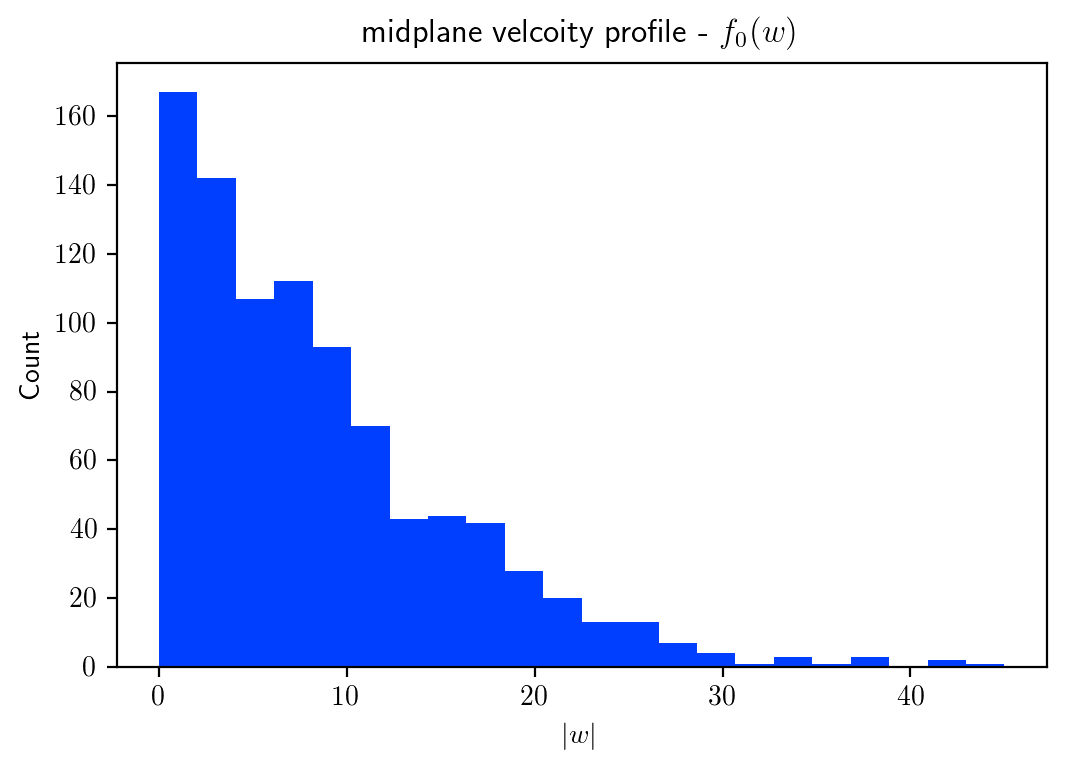

In [52]:
to_save_w_file = True
w_file_name = "grid/star_" + star_Cat + "_hDD_" + str(int(delz)) + "_w_data.txt"

count_w ,_, _=plt.hist(VZ, w_space_edge)

plt.title("midplane velcoity profile - $f_0(w)$");plt.ylabel("Count");plt.xlabel("$|w|$")
wspace, wfunct = an.fetchWDist_gaia(w_in=w_space, count_in=count_w, wspace_out = wspace_in, gaus_approx=False)

if to_save_w_file:
   line_header = "# w bins (km/s), count, count_err"
   np.savetxt(w_file_name , np.transpose( np.array([wspace , wfunct, np.sqrt(wfunct)]) ), delimiter=',', header=line_header, fmt='%10.5f')
   print("Mid-plane velocity saved to: " + w_file_name )

*SDDensity* : The $\sqrt{n}$ error of the density data. (which is than normalized because the error must not contain the evfs weight, but the physical density must.)

*starDensity_norm* : used to normalize the density profile in the data. Here we set the central bin height to unity as normalization (Normalization with midplane density).

interp{x/y/z} are empty arrays initialized for latter to be appended with exclusion plot grid point data. (x for $\Sigma_D$, y for $h_D$ and z for the log-likelihood)

<Container object of 3 artists>

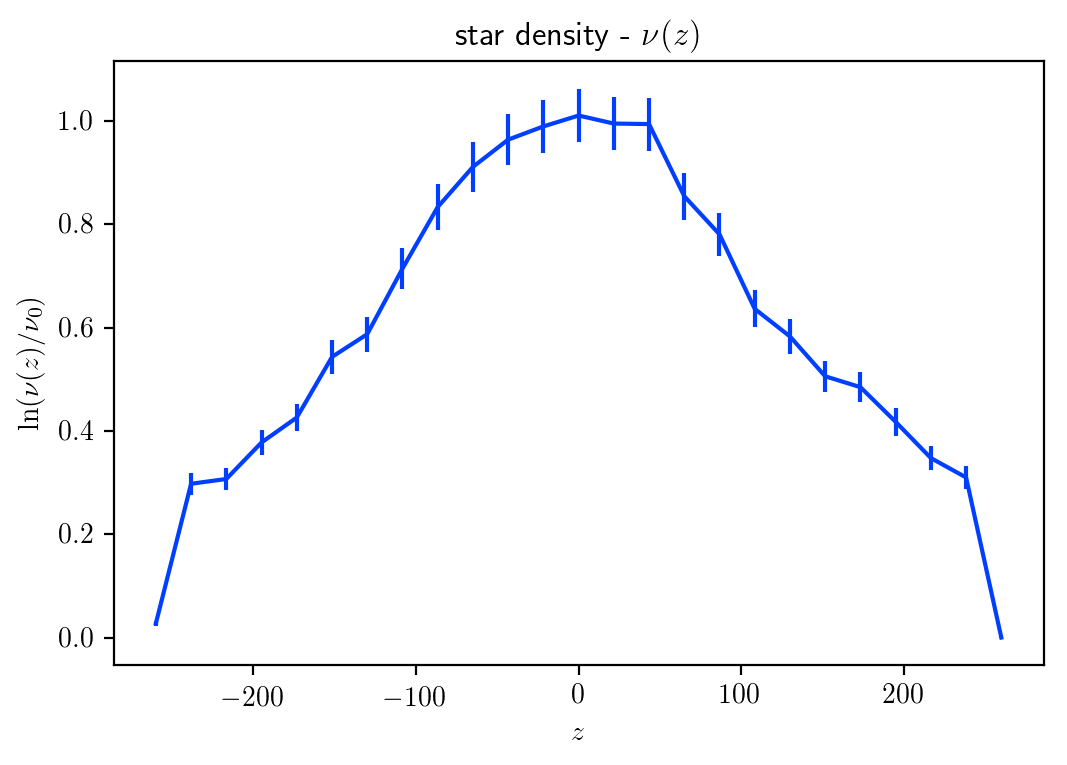

In [53]:
total_sys_err = 0.03

starDensity = an.fetchZDistHist(starFile, zspaceFull, use_evfs = True, show_plot = False)
SDDensity = np.sqrt(an.fetchZDistHist(starFile, zspaceFull, use_evfs = False))
for i, sd in enumerate(SDDensity):
   if sd == 0:
      SDDensity[i] = 1.
   else:
      SDDensity[i] = starDensity[i]/sd
starDensity_norm = np.mean([starDensity[int(np.ceil(len(starDensity)/2.))+k-1] for k in range(3)])

parallax_error = 0.
starDensity = starDensity/starDensity_norm
starDensity_Delta = (SDDensity +  parallax_error)/starDensity_norm + total_sys_err*starDensity

plt.title("star density - $\\nu(z)$"); plt.xlabel("$z$"); plt.ylabel("$\ln(\\nu(z)/\\nu_0)$")
plt.errorbar(zspaceFull, starDensity , yerr=starDensity_Delta)

## Poisson-Jeans Prediction Handling

$\Sigma_D=0$ is a special point, since **1.)** physically its equivalent to no Dark Disk; **2)** all $h_D$ values collapse to a single point (like the $\theta$ coordinate when $r=0$ in polar corrdinates); **3)** *0* generally gives computer program problems if not handled properly (such as division by zero). Therefore we will treat it separately. It best serves as an example for the later loops over the parameter space.

Ignore the "zero_" prefix, which will be dropped later in the full parameter loops. The flow of the program is as follow: 
<newline>
<center>solu - the *potential $\Phi(z)$* solution for Poisson-Jeans equation giving the $\Sigma_D$ and $h_D$, and the internal set baryonic/DM Halo densities.</center>

<center>$\downarrow$</center>

<center>predict - convert the $\Phi(z)$ prediction to the tracer density $\rho(z)$ prediction</center>

<center>$\downarrow$</center>

<center>SDPredict - find the uncertainty of the prediction. Set uncertainty to *0* at the moment (to be incorporated with prediction uncertainty soon)</center>

<center>$\downarrow$</center>

<center>Normalize densities by the midplane density</center>

<center>$\downarrow$</center>

<center> Calculate the Likelihood function </center>
<newline>
We then proceed to, using a for loop, set the whole $\Sigma_D=0$ axis to the output likelihood value, since their value should be the same. We now have a set of likelihood along the $\Sigma_D=0$ strip!

Here is the list of functions used:
- *PoissonJeansSolve* : Solve the Poisson-Jeans solution for the gravitational potential $\Phi(z)$ and output the potential in the user-specified range of space "zRangeLarge". Output format is smooth interpolated function (return type of scipy.interpolation.interp1d).
    Arguments:
    - HD - float. $H_D$.
    - SgmD - float. $\Sigma_D$.
    - zRangeLarge - np.linspace. z range to solve Poisson-Jeans Equation over.


- *fetchZPredict* : Find $\rho(z)$ of the tracers from the gravitational $\Phi(z)$ using $\rho(z) = \rho_0 \int^{\infty}_{2\Phi(z)}\frac{\mathrm{d}w}{\sqrt{w^2-2\Phi(z)}}f_0(w)$. Output $\rho(z)$ as a np.array along the grid spacing specified by the user in "zspaceMed".
    Arguments:
    - solu - scipy.interpolation.interp1d. The gravitational potential $\Phi(z)$.
    - zspaceMed - np.linspace. The z-space grid points across the range of interest.
    - zspaceFull - np.linspace. The grid point of z-space by which $\Phi(z)$ spans.
    - wfunct - np.array. The w-velocity profile extracted from data.
    - wspace - np.linspace. Grid points specifing the space wfunct spans.


- *likelihoodDensity* : output the value (float) of likelihood calculated using the z-bins along the range of z-space specified by l_range_p and l_range_n (upper and lower bound respectively). The likelihood is calculated from the Gaia "starDensity" data, the "predict" data and their respective uncertainties.
    Arguments:
    - zspaceFull - np.linspace. Grid points of z-space that "starDensity" and "predict" span.
    - predict - np.array. Tracer $\rho(z)$ prediction
    - starDensity - np.array. Tracer star density $\rho_{\text{obs}}(z)$ directly from Gaia data set.
    - predict_Delta - np.array. Bins of uncertainty of predict.
    - starDensity_Delta - np.array. Bins of uncertainty of starDensity.
    - l_range_p - float. Upper bound of z-range in which likelihood is calculated bin by bin.
    - l_range_n - float. Same for the lower bound.
        

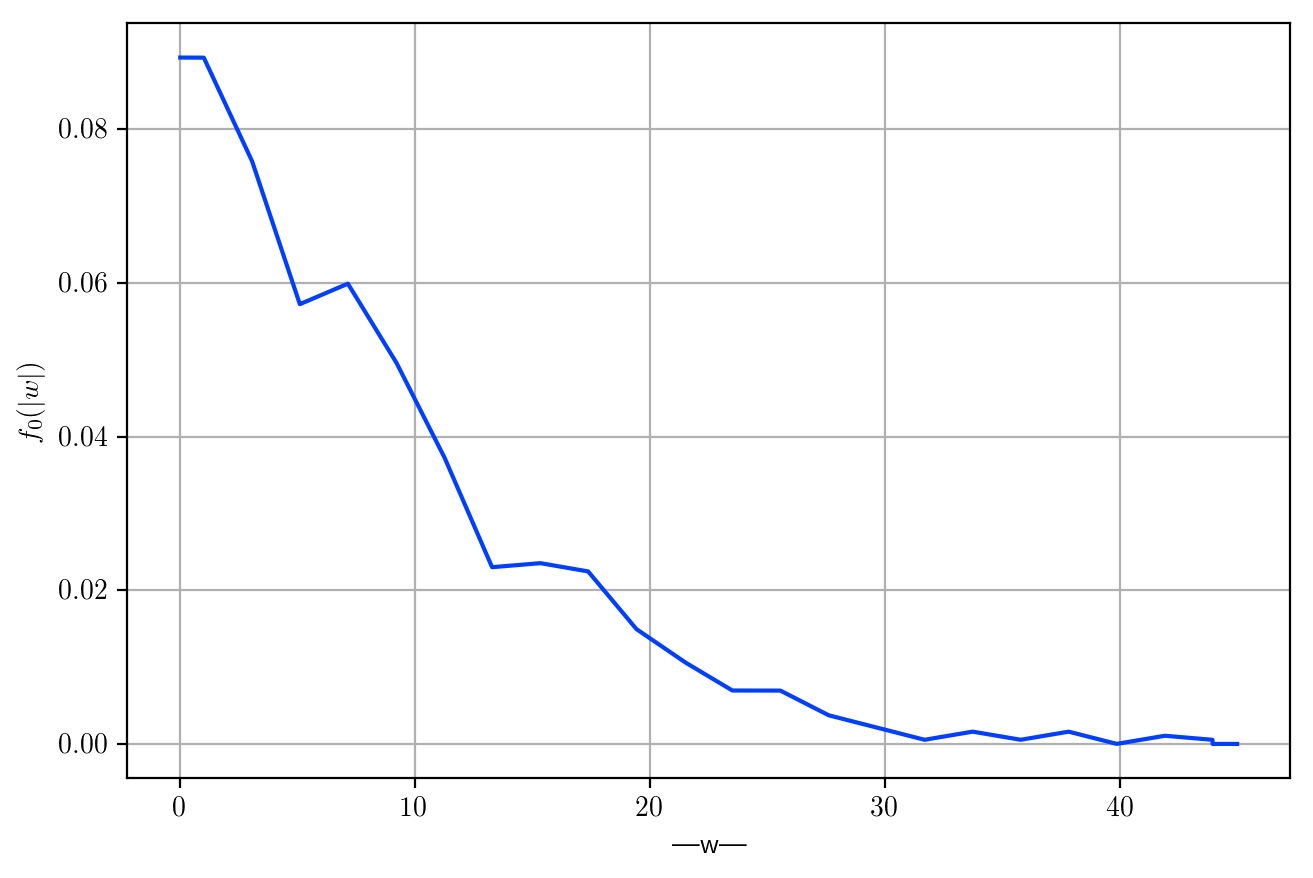

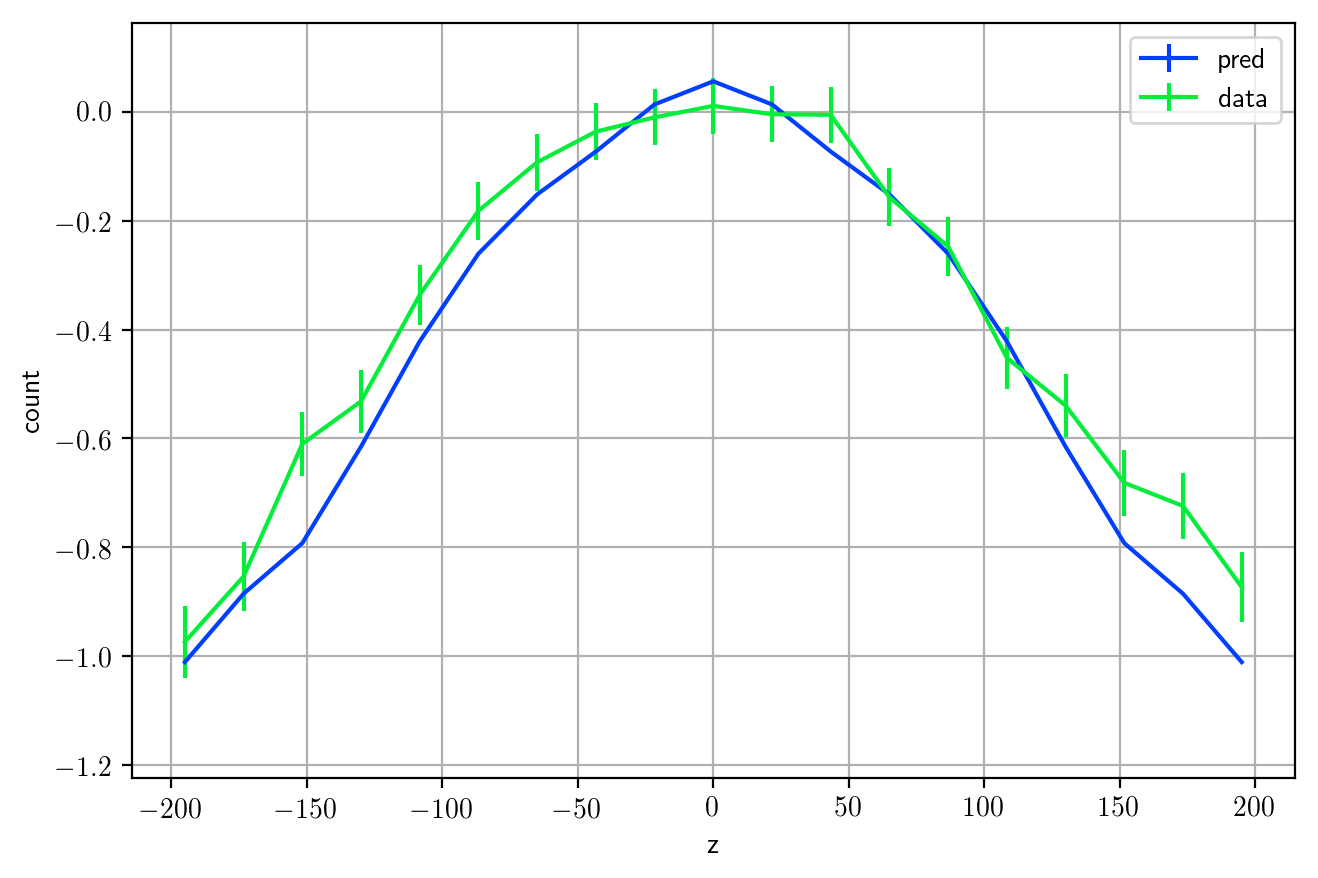

('likelihood is ', -18.124673879499042)


In [54]:
interpz = []
interpy = []
interpx = []
interpxy = []

plt.figure(figsize=(7.5,5.));plt.plot(wspace,wfunct);plt.xlabel('|w|');plt.ylabel('$f_0(|w|)$');plt.grid()
plt.show()
# hDD, SigDD
zero_solu = an.PoissonJeansSolve_gaia(80.,15., zRangeLarge, use_default_density = True)
zero_predict = an.fetchZPredict(zero_solu, zspaceMed, zspaceFull, wfunct, wspace, use_gaus_kernel = False, show_plot=False)
zero_SDPredict = [0. for k in range(len(starDensity_Delta))]
zero_predict_norm = np.mean([zero_predict[int(np.ceil(len(zero_predict)/2.))+k-1] for k in range(3)])
zero_predict = zero_predict/zero_predict_norm
zero_predict_Delta = zero_SDPredict/zero_predict_norm
zero_likelihood = an.likelihoodDensity(zspaceFull, zero_predict, starDensity, zero_predict_Delta, starDensity_Delta, l_range_p, l_range_n, plot_dist = True)

print('likelihood is ', zero_likelihood)

Now we do the same for the whole grid space in $(h_D, \Sigma_D)$, using a double for loop. The only difference is that since our method leads to our original guess $(h_D^{(\text{guess})}, \Sigma_D^{(\text{guess})})$ to be different from the actual $(h_D,\Sigma_D)$ after iteration, we need a function to extract the physical $(h_D,\Sigma_D)$.

- *diskParamReturn* : output a length = 2 list. The first entry is $h_D$ and the second is $\Sigma_D$, both directly calculated from "solu", the potential $\Phi(z)$.
    Arguments:
    - solu - scipy.interpolation.interp1d. The gravitational potential $\Phi(z)$.
    - nHD - float. Raw guess disk height $h_D$.
    - nSgmD - float. Raw guess disk surface density $\Sigma_D$.
    
This is all the difference.

As you can see in the commented-out line, bootstrap function allows us to extract prediction uncertainty (so far we set it to *0* to facilitate computational speed). It can be incorporated in the future.


In [55]:
HD_step = 10
SgmD_step = 1

interpz = []
interpy = []
interpx = []

wfile_columnZCoord = 0
wfile_columnCnt = 1
wfile_columnErr = 2


count, count_err = np.loadtxt(w_file_name, delimiter= ",", skiprows=1, usecols=(wfile_columnCnt, wfile_columnErr), unpack=True)
ext_w_err = count/count_err

for nHD_5 in tqdm(range(1,100,HD_step)):
   for nSgmD_5 in range(1,20,SgmD_step):
      nHD = (nHD_5)
      nSgmD = (nSgmD_5)
      param = [nSgmD, nHD_5]
      solu = an.PoissonJeansSolve_gaia(nHD, nSgmD, zRangeLarge, use_default_density = True)
      #param = an.diskParamReturn(solu, nHD, nSgmD)
    
      predict = an.fetchZPredict(solu, zspaceMed, zspaceFull, wfunct, wspace, show_plot=False)
      #SDPredict = an.bootstrap(predict,zspaceFull, nStars, nBootstrapSample)
      SDPredict = ext_w_err
      predict_norm = predict[int(np.ceil(len(predict)/2.-1))]
      predict = predict/predict_norm
      predict_Delta = SDPredict/predict_norm
    
      likelihood = an.likelihoodDensity(zspaceFull, predict, starDensity, predict_Delta, starDensity_Delta, l_range_p, l_range_n, plot_dist = False)
      interpx.append( float(param[1]) )
      interpy.append( float(param[0]) )
      interpxy.append( [float(param[1]),float(param[0])] )
      interpz.append( float(likelihood) )


/Users/john/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide
100%|██████████| 10/10 [03:02<00:00, 18.30s/it]


## 2D interpolation and exclusion curve presentation

Now with the likelihood values ready, we generate our exclusion plot in our disk parameters space, $(h_D, \Sigma_D)$. First of all, we plot to check the density of data points, which is a measure of how precise our (interpolated) exclusion contour is.

We define the relative log likelihood

<center>$\lambda = 2\big(\,\mathcal{L}(h_D,\Sigma_D)-\text{max}_{\Sigma_D}\mathcal{L}(h_D)\,\big)$.</center>

$\mathcal{L}(h_D,\Sigma_D)$ is our output loglikelihood in the dark disk parameters. This quantity should behave like a chi-squared distribution. We can extract the 95% confident level given the number of degrees of freedom.

For the purpose so far, we maximize the log-likelihood ($\mathcal{L}$) with respect to $\Sigma_D$, along each $h_D$ column (i.e. the list *opt_y_coord*), to approximate our $\text{max}_{\Sigma_D}\mathcal{L}(h_D)$. We generate what our exclusion contour approximately looks like. In reality, we need to optimize $\mathcal{L}$ with respect to $\Sigma_D$ alongside with other nuisance parameters (e.g. baryon densities) **at the same time**. We reserve the precise computation in emcee_gaia.ipynb and the grid-computational codes in script *.py* format.

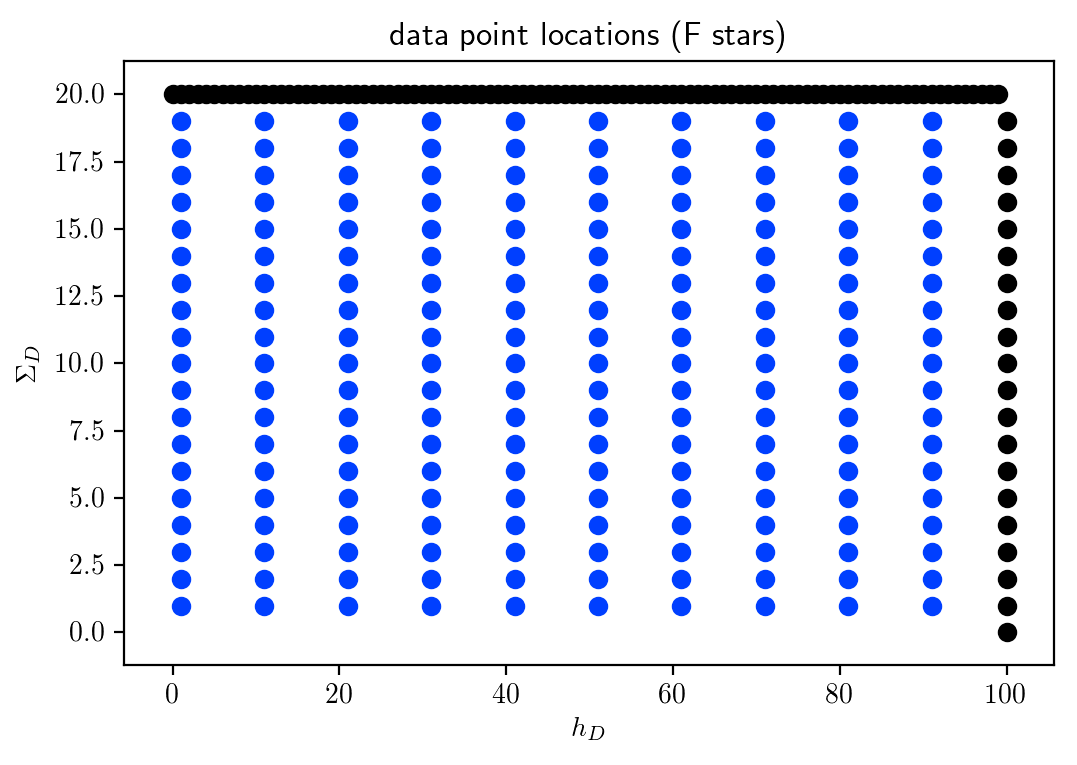

(10, 19)


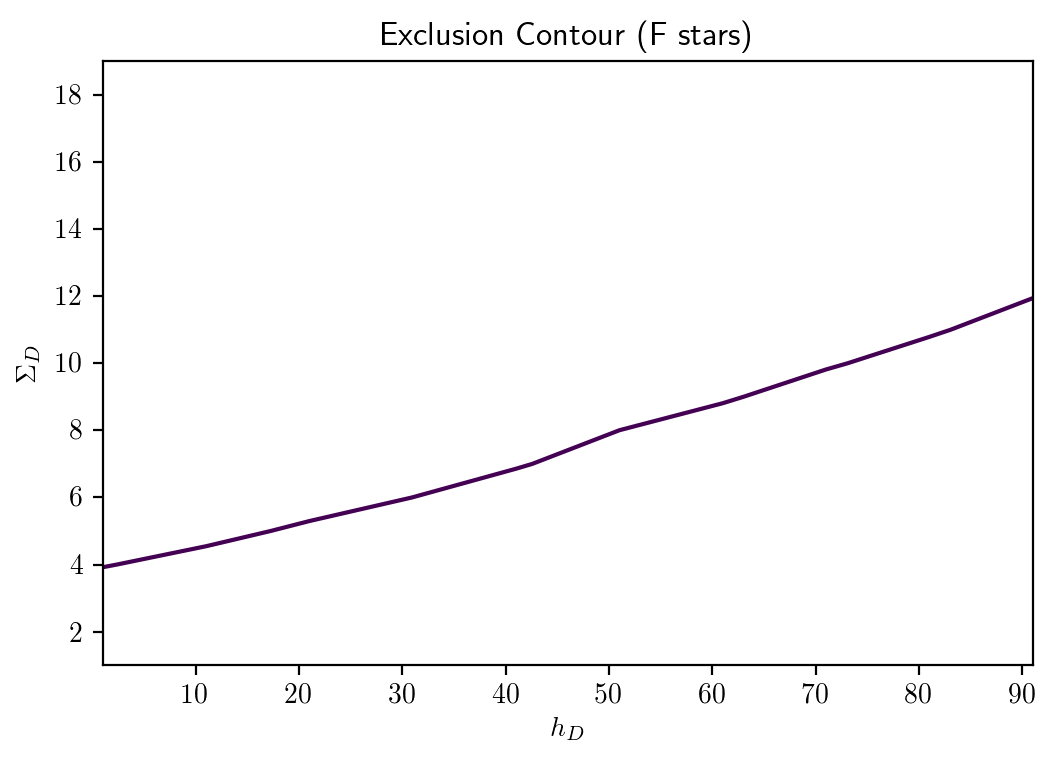

In [57]:
border_x = 100
border_y = 20

plt.scatter(interpx, interpy)
plt.scatter(np.array([border_x for k in range(border_y)]),np.array([k for k in range(border_y)]),color='black')
plt.scatter(np.array([k for k in range(border_x)]),np.array([border_y for k in range(border_x)]),color='black')
plt.title('data point locations ('+star_Cat+' stars)'); plt.ylabel('$\Sigma_D$'); plt.xlabel('$h_D$');
plt.show()

cl_contour = [3.841]

hd_vec = range(1,100,HD_step)
sgm_vec = range(1,20,SgmD_step)

print(len(hd_vec) , len(sgm_vec))


opt_vec = np.array([])
for i, nhd in enumerate(hd_vec):
   opt_value = np.array([])
   for j, sgm in enumerate(sgm_vec):
      entry = i*(20/SgmD_step-1) + j
      try:
         opt_value = np.append(opt_value, interpz[entry])
      except IndexError:
         print entry
   opt_vec = np.append(opt_vec, np.amin(opt_value))

x_grid = []
y_grid = []
z_grid = []
for i, nhd in enumerate(hd_vec):
   x_vec = []
   y_vec = []
   z_vec = []
   for j, sgm in enumerate(sgm_vec):
      entry = i*(20/SgmD_step-1) + j
      x_vec.append(interpx[entry])
      y_vec.append(interpy[entry])
      
      try:
         z_vec.append( 2*(interpz[entry]-opt_vec[i]) )
      except IndexError:
         print entry
      x_grid.append(x_vec)
      y_grid.append(y_vec)
      z_grid.append(z_vec)


plt.contour(x_grid, y_grid, z_grid, cl_contour)
plt.xlabel('$h_D$'); plt.ylabel('$\Sigma_D$'); plt.title('Exclusion Contour ('+star_Cat+' stars)')
plt.show()